roadmap

abc analysis    
pareto diagram
volume forecasting

order picking methods, picking optimisation, routing strategies

## notes from mentors

- Merhaba,  sipariş edilen miktar ve toplanan miktar arasında bazen fark olabilir, sipariş verildikten sonra revize gelmiş olabilir.  sipariş edilen ve gerçekleşen verilerin arasındaki sapma oranını da parametrik olarak dahil edebilirsiniz ya da tamamen ignore edebilirsiniz,

In [1]:
import pandas as pd
import numpy as np

In [2]:
order_df = pd.read_csv('datathon_order.csv', parse_dates=['Sipariş Tarihi'])
picking_df = pd.read_csv('datathon_picking.csv', index_col='Unnamed: 0', parse_dates=['Toplama Tarihi'])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
order_df.columns = ['order_num', 'order_item', 'order_type', 'material_num', 'order_amount', 
                    'palette_std', 'customer_num', 'order_date', 'operation_type']

In [4]:
picking_df.columns = ['order_num', 'order_type', 'material_num', 'picked_amount', 'picking_date', 
                      'picking_hour', 'order_receive_date', 'shipping_date', 'customer_num', 'operation_type']

In [5]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [6]:
picking_df.columns

Index(['order_num', 'order_type', 'material_num', 'picked_amount',
       'picking_date', 'picking_hour', 'order_receive_date', 'shipping_date',
       'customer_num', 'operation_type'],
      dtype='object')

In [7]:
picking_df['picking_date'] = picking_df['picking_date'].apply(convert_string_to_date)
picking_df['order_receive_date'] = picking_df['order_receive_date'].apply(convert_string_to_date)
picking_df['shipping_date'] = picking_df['shipping_date'].apply(convert_string_to_date)
picking_df['picking_hour'] = pd.to_datetime(picking_df['picking_hour'])

In [8]:
order_df['order_item'] = order_df['order_item'].fillna(0)

In [9]:
order_df['order_num'] = order_df['order_num'].astype('str')
order_df['order_item'] = order_df['order_item'].astype('int16')
order_df['material_num'] = order_df['material_num'].astype('str')
order_df['order_amount'] = order_df['order_amount'].astype('int32')

# order_df['order_type'] = order_df['order_type'].astype('category')
# order_df['palette_std'] = order_df['palette_std'].astype('category')
# order_df['customer_num'] = order_df['customer_num'].astype('category')
# order_df['operation_type'] = order_df['operation_type'].astype('category')

In [10]:
picking_df.head()

,order_num,order_type,material_num,picked_amount,picking_date,picking_hour,order_receive_date,shipping_date,customer_num,operation_type
0,72616784,10.0,61000058,45,2019-12-28,2021-11-11 11:10:00,2019-12-26,2020-01-02,C10005,O1
1,72616784,10.0,61000058,45,2019-12-28,2021-11-11 11:11:00,2019-12-26,2020-01-02,C10005,O1
2,72616784,10.0,61000058,45,2019-12-28,2021-11-11 11:11:00,2019-12-26,2020-01-02,C10005,O1
3,72616784,10.0,61000058,45,2019-12-28,2021-11-11 11:12:00,2019-12-26,2020-01-02,C10005,O1
4,72616784,10.0,61000058,45,2019-12-28,2021-11-11 11:10:00,2019-12-26,2020-01-02,C10005,O1


In [11]:
picking_df['order_num'] = picking_df['order_num'].astype('str')
picking_df['material_num'] = picking_df['material_num'].astype('str')
picking_df['picked_amount'] = picking_df['picked_amount'].astype('int32')

# picking_df['order_type'] = picking_df['order_type'].astype('category')
# picking_df['customer_num'] = picking_df['customer_num'].astype('category')
# picking_df['operation_type'] = picking_df['operation_type'].astype('category')

In [12]:
order_df.isna().sum()

order_num           0
order_item          0
order_type         12
material_num        0
order_amount        0
palette_std       935
customer_num        0
order_date          0
operation_type      0
dtype: int64

In [13]:
picking_df.isna().sum()

order_num                 0
order_type            27970
material_num              0
picked_amount             0
picking_date              0
picking_hour              0
order_receive_date        0
shipping_date             0
customer_num              5
operation_type            0
dtype: int64

In [14]:
picking_df[picking_df['customer_num'].isna()].material_num.unique()

array(['10000692', '10000000', '10187005'], dtype=object)

In [15]:
picking_df[picking_df['material_num']=='10187005']['customer_num'].unique()

array([nan], dtype=object)

In [16]:
num_unique_values_in_groups = order_df.groupby(['order_num', 'material_num']).agg({'order_item':'count',
                                                     'order_type':'nunique',
                                                     'order_amount':'sum',
                                                     'palette_std':'nunique',
                                                     'customer_num':'nunique',
                                                     'order_date':'nunique',
                                                     'operation_type':'nunique'
                                                     })

In [17]:
num_unique_values_in_groups.max()

order_item           16
order_type            1
order_amount      21000
palette_std           2
customer_num          2
order_date            1
operation_type        1
dtype: int64

In [18]:
palette_std ve customer_num sorularının cevabına göre groupby'ı revize et

SyntaxError: invalid syntax (<ipython-input-18-4c083ab8598c>, line 1)

In [19]:
order_df = order_df.groupby(['order_num', 'material_num']).agg({'order_item':'count',
                                                     'order_type':'max',
                                                     'order_amount':'sum',
                                                     'palette_std':'max',
                                                     'customer_num':'max',
                                                     'order_date':'max',
                                                     'operation_type':'max'
                                                     }).reset_index()

In [24]:
merged_df = pd.merge(order_df, picking_df, on=['order_num', 'material_num'], how='left')

In [43]:
merged_df.head(3)

,order_num,material_num,order_item,order_type_x,order_amount,palette_std,customer_num_x,order_date,operation_type_x,order_type_y,picked_amount,picking_date,picking_hour,order_receive_date,shipping_date,customer_num_y,operation_type_y
0,1161248270,4016984,1,NaN,24,210.0,M10354,2020-02-05,O2,NaN,210.0,2020-02-05,2021-11-11 14:38:00,2020-02-05,2020-02-06,M1269,O2
1,1161248270,91704,1,NaN,2,80.0,M10354,2020-02-05,O2,NaN,80.0,2020-02-05,2021-11-11 14:38:00,2020-02-05,2020-02-06,M1269,O2
2,4507790922,4027905,1,NaN,40,210.0,M10140,2020-08-25,O2,NaN,210.0,2020-08-25,2021-11-11 13:56:00,2020-08-25,2020-08-25,M577,O2


In [26]:
merged_df.isna().sum()

order_num                 0
material_num              0
order_item                0
order_type_x             31
order_amount              0
palette_std            3151
customer_num_x            0
order_date                0
operation_type_x          0
order_type_y          26963
picked_amount         26932
picking_date          26932
picking_hour          26932
order_receive_date    26932
shipping_date         26932
customer_num_y        26932
operation_type_y      26932
dtype: int64

In [53]:
import matplotlib.pyplot as plt

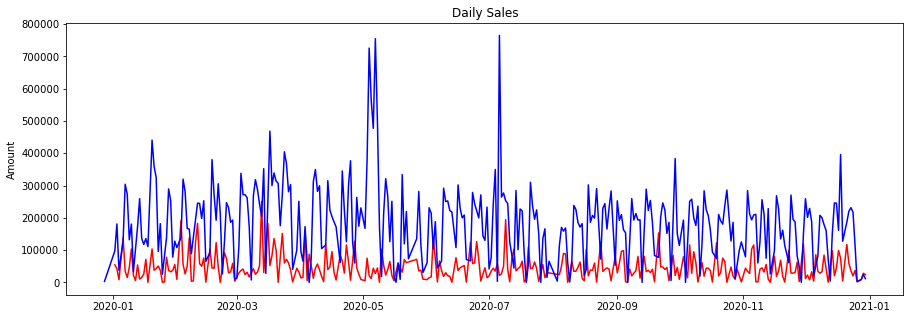

In [62]:
daily_orders = order_df.groupby(['order_date'])['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(daily_orders.index, daily_orders.values, 'r')
plt.plot(daily_picking.index, daily_picking.values, 'b')
plt.title('Daily Sales and Picking')
plt.ylabel('Amount')
plt.show();

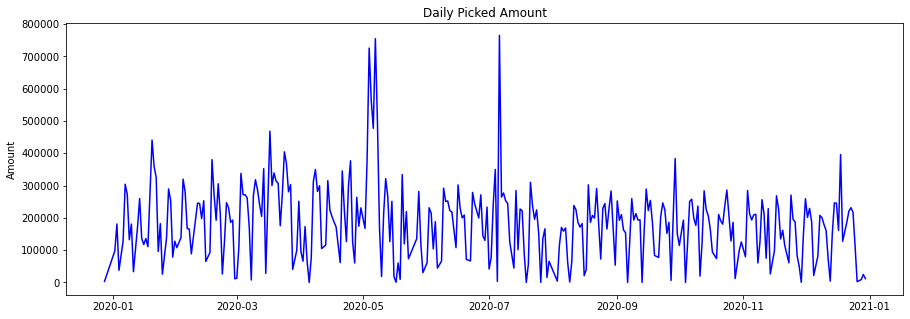

In [61]:
daily_picking = picking_df.groupby(['picking_date'])['picked_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(daily_picking.index, daily_picking.values, 'b')
plt.title('Daily Picked Amount')
plt.ylabel('Amount')
plt.show();

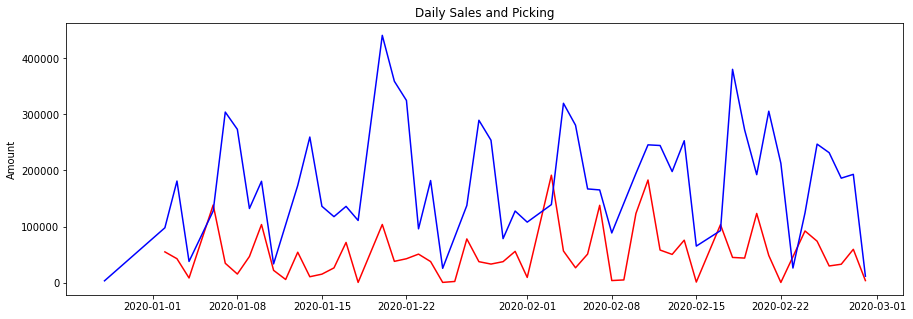

In [67]:
daily_orders = order_df[order_df['order_date']<'2020-03-01'].groupby(['order_date'])['order_amount'].sum()
daily_picking = picking_df[picking_df['picking_date']<'2020-03-01'].groupby(['picking_date'])['picked_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(daily_orders.index, daily_orders.values, 'r')
plt.plot(daily_picking.index, daily_picking.values, 'b')
plt.title('Daily Sales and Picking')
plt.ylabel('Amount')
plt.show();

In [ ]:
merged_df.sum()

### ABC analysis

In [ ]:
order_df.groupby(['order_date'])['order_amount'].plot(kind='kde')

In [ ]:
malzeme_volume_perc = order_df['Malzeme Numarası'].value_counts(normalize=True).reset_index()
malzeme_volume_perc.columns = ['malzeme', 'volume_percentage']
malzeme_volume_perc['cum_perc'] = malzeme_volume_perc['volume_percentage'].cumsum()

In [ ]:
malzeme_volume_perc.loc[:,'ABC'] = 'C'
malzeme_volume_perc.loc[malzeme_volume_perc['cum_perc']<0.5,'ABC'] = 'B'
malzeme_volume_perc.loc[malzeme_volume_perc['cum_perc']<0.2,'ABC'] = 'A'

In [ ]:
malzeme_volume_perc['ABC'].value_counts(normalize=True)

In [ ]:
pd.Timestamp(2011,3,20)

In [ ]:
len('05/03/2020')

In [ ]:
picking_df['Sevkiyat Tarihi'].unique()

In [ ]:
picking_df.dtypes